# Project: Unsupervised Learning - Clustering for Fraud Detection on Bank Transactions

<br>

### Problem:
- Identify fraud cases from amount and type (e.g. leisure, food, etc) of bank transactions
- Unsupervised Learning using clustering (igonre labels for fraud or non-fraud) using KMeans and DBSCAN

<br>

### Tools:
- pre-processing: MinMaxScaler
- Models: MiniBatchKMeans (efficient KMeans), DBSCAN
- Model validation and hyperparameter search: elbow curve, train_test_split
- Error Metrics: homogeneity_score, silhouette_score, classification_report, confusion_matrix, r2_score, roc_auc_score 

<br>

### load defaults

In [10]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import myML_functions as myML_functions

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score, roc_auc_score 
from sklearn.metrics import homogeneity_score, silhouette_score 

<br>

## 1 - Destinguish between normal and abnormal behavior with EDA
- very large transactions or many transactions in a short period of time
- is data homogeneous or do different types of clients display very different behaviour?
- segment data: find groups with similar behaviour to define normal and abnormal behaviour

In [30]:
df = pd.read_csv('./data/Fraud/chapter_3/banksim.csv')
print(df.groupby('category').mean())

                          Unnamed: 0      amount     fraud
category                                                  
es_barsandrestaurants  267372.707865   43.841793  0.022472
es_contents            335906.153846   55.170000  0.000000
es_fashion             286952.226804   59.780769  0.020619
es_food                334978.976190   35.216050  0.000000
es_health              335355.176955  126.604704  0.242798
es_home                248312.583333  120.688317  0.208333
es_hotelservices       280138.548387  172.756245  0.548387
es_hyper               244440.712500   46.788180  0.125000
es_leisure             186541.307692  229.757600  1.000000
es_otherservices       241279.000000  149.648960  0.600000
es_sportsandtoys       238775.539474  157.251737  0.657895
es_tech                310473.948718  132.852862  0.179487
es_transportation      295733.881674   27.422014  0.000000
es_travel              338897.777778  231.818656  0.944444
es_wellnessandbeauty   275085.979798   66.167078  0.0606

leisure and travel related transactions have high rates of fraud

In [4]:
df = pd.read_csv('./data/Fraud/chapter_3/banksim_adj.csv')
print(df[['age','amount','fraud']].groupby('age').mean())

        amount     fraud
age                     
0    49.468935  0.050000
1    35.622829  0.026648
2    37.228665  0.028718
3    37.279338  0.023283
4    36.197985  0.035966
5    37.547521  0.023990
6    36.700852  0.022293


no particular trend with age

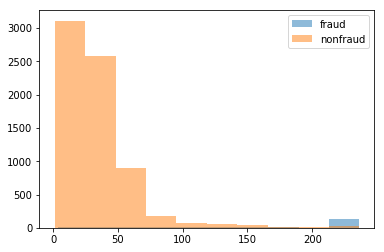

In [5]:
df_fraud = df.loc[df['fraud'] == 1] 
df_non_fraud = df.loc[df['fraud'] == 0]

# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud['amount'], alpha=0.5, label='fraud')
plt.hist(df_non_fraud['amount'], alpha=0.5, label='nonfraud')
plt.legend()
plt.show()

fraud transactions tend to be for large amounts

### 1.1 - Print Results Functons and MinMaxScaler

In [12]:
def print_model_result(y_true, y_predicted):
    
    print(f"R2: {r2_score(y_true, y_predicted):0.3f}")
    print(f"Roc_Auc: {roc_auc_score(y_true, y_predicted):0.3f}\n")
    
    print('Classifcation report:\n', classification_report(y_true, y_predicted))
    #conf_mat = confusion_matrix(y_test, predicted)
    #print('Confusion matrix:\n', conf_mat)
    class_names = np.array(['Non-Fraud', 'Fraud'])
    myML_functions.plot_confusion_matrix(y_true, y_predicted, classes=class_names)
    plt.show()

MinMaxScaler

In [6]:
df = pd.read_csv('./data/Fraud/chapter_3/banksim_adj.csv')
y = df['fraud']
df.drop('fraud', axis=1)
X = np.array(df).astype(np.float)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

<br>

## 2 - Detect Fraud with K-means clustering (cluster outliers)
- choose number of clusters with Elbow curve

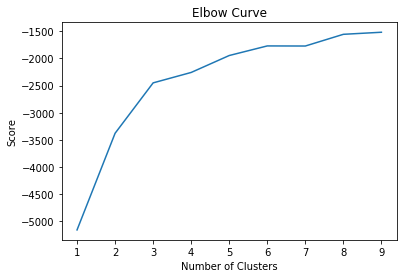

In [7]:
clustno = range(1, 10)

kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

**use 4 clusters**

### 2.1 - Assigning fraud versus non-fraud using distance from cluster centroid
- assign centroids, compute distances to cluster centroid, define a percentile for the distance distribution and remove anything with distance larger than that

R2: 0.114
Roc_Auc: 0.988

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      2099
           1       0.54      1.00      0.70        58

   micro avg       0.98      0.98      0.98      2157
   macro avg       0.77      0.99      0.84      2157
weighted avg       0.99      0.98      0.98      2157

Confusion matrix, without normalization


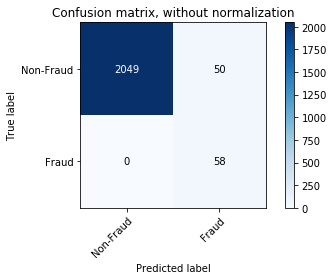

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)

kmeans = MiniBatchKMeans(n_clusters=4, random_state=42).fit(X_train)

# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Create fraud predictions based on outliers on clusters 
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0

print_model_result(y_test, km_y_pred)

<br>

## 3 - Detect Fraud with DBSCAN clustering (smallest clusters)
<img src='./img/clustering.png' align='left' width='400px'>

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)

db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(X_train)

pred_labels = db.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in y else 0)

print('Estimated number of clusters: %d' % n_clusters)
print("Homogeneity: %0.3f" % homogeneity_score(y_train, pred_labels))
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_train, pred_labels))

Estimated number of clusters: 20
Homogeneity: 0.862
Silhouette Coefficient: 0.556


In [23]:
def dbscan_predict(model, X):
    nr_samples = X.shape[0]

    y_new = np.ones(shape=nr_samples, dtype=int) * -1

    for i in range(nr_samples):
        diff = model.components_ - X[i, :]  # NumPy broadcasting

        dist = np.linalg.norm(diff, axis=1)  # Euclidean distance

        shortest_dist_idx = np.argmin(dist)

        if dist[shortest_dist_idx] < model.eps:
            y_new[i] = model.labels_[model.core_sample_indices_[shortest_dist_idx]]

    return y_new

Predict new labels on test dataset

In [24]:
pred_labels = dbscan_predict(db, X_test)
n_clusters = len(set(pred_labels)) - (1 if -1 in y else 0)

print('Estimated number of clusters: %d' % n_clusters)
print("Homogeneity: %0.3f" % homogeneity_score(y_test, pred_labels))
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_test, pred_labels))

Estimated number of clusters: 20
Homogeneity: 0.868
Silhouette Coefficient: 0.559


find the smallest clusters to identify as fraud

In [35]:
counts = np.bincount(pred_labels[pred_labels>=0])
print(counts)

# Sort the sample counts of the clusters and take the smallest clusters
smallest_clusters = np.argsort(counts)[:10]

print("The smallest clusters are clusters:")      
print(smallest_clusters)

print("Their counts are:")      
print(counts[smallest_clusters])

[845  27  13 927  20  39  36  12  26  12  19  30  53  16   7   7   4   4
   9]
The smallest clusters are clusters:
[16 17 15 14 18  7  9  2 13 10]
Their counts are:
[ 4  4  7  7  9 12 12 13 16 19]


test fraud detection accuracy with DBSCAN

R2: -0.719
Roc_Auc: 0.759

Classifcation report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      2099
           1       0.31      0.55      0.40        58

   micro avg       0.96      0.96      0.96      2157
   macro avg       0.65      0.76      0.69      2157
weighted avg       0.97      0.96      0.96      2157

Confusion matrix, without normalization


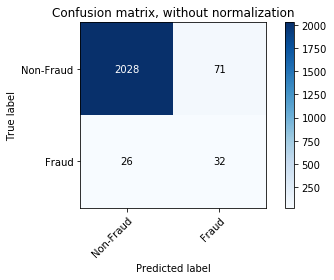

In [36]:
db_df = pd.DataFrame({'clusternr':pred_labels, 'fraud':y_test})

db_df['predicted_fraud'] = 0
for cluster in smallest_clusters:
    db_df['predicted_fraud'].loc[db_df['clusternr']==cluster] = 1
    
#db_df['predicted_fraud'] = np.where((db_df['clusternr']==21) | (db_df['clusternr']==9),1 , 0)

print_model_result(db_df['fraud'], db_df['predicted_fraud'])